# Analyzing the Spectrum of Explainability in Outcome-Oriented Predictive Process Monitoring

## Traffic fines 1

### data preprocessing

#### importing libraries and terminology

In [1]:
#import libraries

In [189]:
import pandas as pd
from pandas import Series
import numpy as np
import time
import random
import pickle

from sklearn.preprocessing import StandardScaler
#MinMaxScaler

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OrdinalEncoder

#user specified packages from Teinemaa
import EncoderFactory
from DatasetManager import DatasetManager



#visualisation packages
import graphviz
from sklearn import tree
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from sklearn.datasets import *
from sklearn import tree
from dtreeviz.trees import *

#import shap
import shap

#models
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

#IBM package models
from aix360.algorithms.rbm import FeatureBinarizer
from aix360.algorithms.rbm import LogisticRuleRegression

#LSTM
import logging
from collections import OrderedDict
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM, GRU, Dropout, Input, Reshape, Activation, Multiply, TimeDistributed, concatenate, BatchNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
#terminology

In [4]:
params_dir = './params_dir'
results_dir = './results' 
DT_dir = './DT_dir'
cls_encoding = 'agg'

gap = 1
n_iter = 1

dataset_ref_to_datasets = {
    "bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(1,6)],
    "insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"],
    "onehot": ["static", "onehot"]
}

train_ratio = 0.8
random_state = 22

In [5]:
dataset_ref = 'traffic_fines_1'
datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]

In [6]:
# print dataset name

In [7]:
for dataset_name in datasets:
    print('Dataset:', dataset_name)

Dataset: traffic_fines_1


In [8]:
# read the data

In [9]:
dataset_manager = DatasetManager(dataset_name)
data = dataset_manager.read_dataset()
cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}

In [10]:
# determine min and max (truncated) prefix lengths

In [11]:
min_prefix_length = 1
if "traffic_fines" in dataset_name:
    max_prefix_length = 10
elif "bpic2017" in dataset_name:
    max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
else:
    max_prefix_length = min(40, dataset_manager.get_pos_case_length_quantile(data, 0.90))

In [291]:
data.shape[0]

460556

#### EDA

In [13]:
#data types

In [14]:
data.dtypes

article                       object
vehicleClass                  object
amount                       float64
points                       float64
Case ID                       object
Activity                      object
Resource                      object
lastSent                      object
notificationType              object
dismissal                     object
expense                      float64
Complete Timestamp    datetime64[ns]
timesincemidnight            float64
month                        float64
weekday                      float64
hour                         float64
timesincelastevent           float64
timesincecasestart           float64
event_nr                     float64
open_cases                   float64
label                         object
dtype: object

In [15]:
#print first 5 rows of the data

In [16]:
data.head()

,article,vehicleClass,amount,points,Case ID,Activity,Resource,lastSent,notificationType,dismissal,...,Complete Timestamp,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases,label
0,157.0,A,35.0,0.0,A100,Create Fine,561.0,missing,missing,NIL,...,2006-08-02 01:00:00,60.0,8.0,2.0,1.0,0.0,0.0,1.0,11246.0,deviant
1,157.0,A,35.0,0.0,A100,Send Fine,561.0,missing,missing,NIL,...,2006-12-12 01:00:00,60.0,12.0,1.0,1.0,190080.0,190080.0,2.0,12380.0,deviant
2,157.0,A,35.0,0.0,A100,Insert Fine Notification,561.0,P,P,NIL,...,2007-01-15 01:00:00,60.0,1.0,0.0,1.0,48960.0,239040.0,3.0,12202.0,deviant
3,157.0,A,71.5,0.0,A100,Add penalty,561.0,P,P,NIL,...,2007-03-16 01:00:00,60.0,3.0,4.0,1.0,86400.0,325440.0,4.0,7749.0,deviant
4,157.0,A,36.0,0.0,A10000,Create Fine,561.0,missing,missing,NIL,...,2007-03-09 01:00:00,60.0,3.0,4.0,1.0,0.0,0.0,1.0,7756.0,regular


In [17]:
import pylab as pl

In [18]:
#histogram of the event numbers

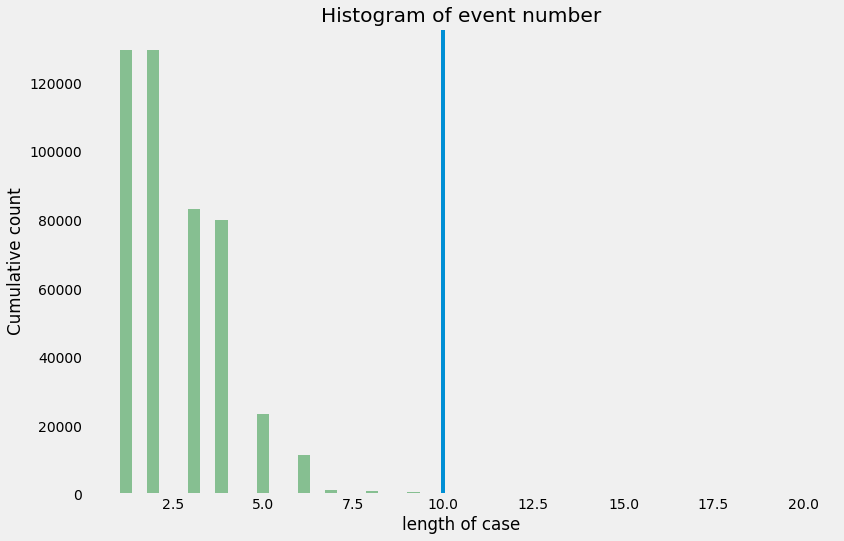

In [19]:
histo = data.hist(column='event_nr',bins=50, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
pl.title("Histogram of event number")
pl.xlabel("length of case")
pl.ylabel("Cumulative count")
plt.axvline(x=10, ymin=0, ymax=1)

In [20]:
#maximal length of an event

In [21]:
max_event = data['event_nr'].max()
max_event

20.0

#### data preprocessing

In [22]:
# split into training and test
train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")

In [23]:
#prefix generation of train and test data

In [24]:
print('prefixing started')
dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length)
dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)

prefixing started


In [25]:
#get the label of the train and test set
test_y = dataset_manager.get_label_numeric(dt_test_prefixes)
train_y = dataset_manager.get_label_numeric(dt_train_prefixes)   

In [26]:
auc_totals = []
preds_all = []
test_y_all = []
nr_events_all = []
offline_total_times = []
online_event_times = []

In [27]:
nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_prefixes)))  
test_y_all.extend(test_y)

#### feature combiner and columns

In [288]:
feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **cls_encoder_args)) for method in methods])
feature_combiner.fit(dt_train_prefixes, train_y)
    
#transform train dataset and add the column names back to the dataframe
dt_train_named = feature_combiner.transform(dt_train_prefixes)
dt_train_named = pd.DataFrame(dt_train_named)
names= feature_combiner.get_feature_names()
dt_train_named.columns = names

In [238]:
#transform test dataset
dt_test_named = feature_combiner.transform(dt_test_prefixes)
dt_test_named = pd.DataFrame(dt_test_named)
names= feature_combiner.get_feature_names()
dt_test_named.columns = names

In [239]:
dt_train_named_original = dt_train_named.copy()
dt_test_named_original = dt_test_named.copy()

In [240]:
dt_train_named = dt_train_named_original.copy()
dt_test_named = dt_test_named_original.copy()

#### feature selection columns

aggregation columns

In [107]:
#all columns
columns_all = list(dt_train_named.columns)

In [108]:
#15% PC

In [109]:
columns_PC15 = ['agg__Activity_Payment', 'agg__Activity_Send Fine']

In [110]:
#10% PC

In [111]:
columns_PC10 = ['agg__Activity_Payment', 'agg__Activity_Send Fine', 'agg__Activity_Insert Date Appeal to Prefecture']

#### values to change

In [241]:
#############################
#######VALUES TO CHANGE######
#############################

In [242]:
columns = columns_PC10

In [243]:
column_selection = 'PC10'

In [250]:
cls_method ='xgboost'
method_name = "%s_%s"%(column_selection, cls_encoding)

In [251]:
if gap > 1:
    outfile = os.path.join(results_dir, "performance_results_%s_%s_%s_gap%s.csv" % (cls_method, dataset_name, method_name, gap))
else:
    outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))

In [252]:
#method_name

In [253]:
method_name

'PC10_agg'

In [254]:
# load optimal params

In [255]:
optimal_params_filename = os.path.join(params_dir, "optimal_params_%s_%s_%s.pickle" % (cls_method, dataset_name, method_name))
if not os.path.isfile(optimal_params_filename) or os.path.getsize(optimal_params_filename) <= 0:
    print('problem')

with open(optimal_params_filename, "rb") as fin:
    args = pickle.load(fin)
    print(args)

{'colsample_bytree': 0.55404684413016, 'learning_rate': 0.2689454648351185, 'max_depth': 28, 'min_child_weight': 4, 'subsample': 0.6821323160544785}


In [256]:
dt_train_named = dt_train_named[columns]
dt_test_named = dt_test_named[columns]

### LLM

#### model

In [122]:
current_args = args 

In [156]:
cls_dt = tree.DecisionTreeClassifier(criterion= 'entropy', 
                                 max_depth= args['max_depth'], 
                                 min_samples_leaf= args['min_samples_leaf'], 
                                 random_state = random_state)
cls_dt.fit(dt_train_named,train_y)

DecisionTreeClassifier(criterion='entropy', max_depth=1, min_samples_leaf=310,
                       random_state=22)

In [ ]:
#add an extra column with the number of the leave node
#these can be seen as the homogeneuous segments (buckets)
dt_train_named['cluster'] = cls.apply(dt_train_named)
dt_test_named['cluster'] = cls.apply(dt_test_named)
cluster_number = list(dt_test_named['cluster'] )
train_y_concat = pd.DataFrame(train_y)
train_y_concat = train_y_concat.rename(columns={train_y_concat.columns[0]:'label'})
dt_train_named = pd.concat([dt_train_named,train_y_concat], axis=1)
test_y_concat  = pd.DataFrame(test_y)
test_y_concat  = test_y_concat.rename(columns={test_y_concat.columns[0]:'label'})
dt_test_named = pd.concat([dt_test_named, test_y_concat], axis=1)

In [125]:
#list of leaves that contain test data 
leaves = list((dt_test_named['cluster'].unique()))
a = np.array(cluster_number)
b = np.array(nr_events_all)

#reorder the event numbers
event_list = []
for i in leaves:
    event_list.extend(b[a==i].tolist())

In [126]:
leaves

[1, 2]

In [158]:
classifiers = []
aucs = []
auc_totals = []
preds_all = []
test_y_all = []
print('model after DT started')
avg_runtime = []
start = time.time()
for i in leaves:  
    #only take the data from the leave, seperate the label from the independent features
    data_train_x = dt_train_named[dt_train_named['cluster']==i].copy()
    data_train_y = data_train_x['label'].copy()
    
    data_test_x  = dt_test_named[dt_test_named['cluster']==i].copy()
    data_test_y  = data_test_x['label'].copy()
        
    #drop the columns
    data_train_x = data_train_x.drop('label', axis=1)
    data_train_x = data_train_x.drop('cluster', axis=1)
    data_test_x = data_test_x.drop('label', axis=1)
    data_test_x = data_test_x.drop('cluster', axis=1)
        
    
    #if there is only one label in the training data, no need to create a leaf model
    if len(set(data_train_y))<2:
        pred = [data_train_y.iloc[0]]*len(data_test_y)
        preds_all.extend(pred)
        test_y_all.extend(data_test_y)
        classifiers.append('only one training label')
        try:
            auc = roc_auc_score(data_test_y,preds)
            aucs.append(auc)
        except:
            #perfect classifcation so an AUC of 1
            auc=1
            aucs.append(auc)
                
    else:  
        #print length of test and training data of the leaf node
        l = [["length test data", len(data_test_x)], ["length training data", len(data_train_x)]]
        table = tabulate(l, tablefmt='orgtbl')
        print(table)
        test_y_all.extend(data_test_y)
            
        if cls_method == 'llm':
                scaler = StandardScaler()
                data_train_x2= scaler.fit_transform(data_train_x)
                data_test_x2= scaler.transform(data_test_x)
                data_train_x = pd.DataFrame(data_train_x2, columns = data_train_x.columns)
                data_test_x = pd.DataFrame(data_test_x2, columns = data_test_x.columns)
                preds_pos_label_idx = np.where(cls_dt.classes_ == 1)[0][0]
                logreg = LogisticRegression(max_iter= 10000000, 
                                            penalty= 'l1', solver='saga')     
                logreg.fit(data_train_x, data_train_y)
                
                pred = logreg.predict_proba(data_test_x)
                pred = pred[:,preds_pos_label_idx]
                logmodel=pd.DataFrame({'odds_ratio':(np.exp(logreg.coef_).T).tolist(),'variable':data_train_x.columns.tolist()})
                logmodel['odds_ratio'] = logmodel['odds_ratio'].str.get(0)
                logmodel=logmodel.sort_values('odds_ratio', ascending=False)
                #logs
                coefs = {"coef": ["coef_%s"%i]}
                coef = coefs['coef'][0]
                coefhelp = logmodel
                exec(coef + "=coefhelp")
                #coefficients
                orig_coefs = {"orig_coef": ["orig_coef_%s"%i]}
                orig_coef = orig_coefs['orig_coef'][0]
                orig_coefhelp = logreg.coef_
                exec(orig_coef + "=orig_coefhelp")
                        
                #this seperation is solely to be able to calculate the AUC for every leaf node model
                if len(set(data_test_y))>1:
                    auc = roc_auc_score(data_test_y, pred)
                    print(auc)
                    aucs.append(auc)
                    preds_all.extend(pred)
                    classifiers.append('leaf model')                    
                            
                elif len(set(data_test_y))==1:
                    auc = 1
                    aucs.append(auc)
                    preds_all.extend(pred)
                    classifiers.append('leaf model')
                    
total_time = time.time() - start
avg_runtime.append(total_time/ (len(dt_train_named)+len(dt_test_named)))

auc_total = roc_auc_score(test_y_all, preds_all)
    
    

print("results are up")        

model after DT started
| length test data     |  72511 |
| length training data | 298333 |
0.688402174321772
| length test data     | 16019 |
| length training data | 63761 |
0.8543530055971277
results are up


In [159]:
print(auc_total)

0.7892031417174193


In [160]:
cf = []
for i in leaves:
    coefficients  = "coef_%s"%i
    cf.append(coefficients)

In [161]:
cf

['coef_1', 'coef_2']

In [162]:
with open(outfile, 'w') as fout:
        fout.write("%s;%s;%s;%s;%s;%s\n"%("dataset", "method", "cls", "nr_events", "metric", "score"))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_total", total_time))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_avg", avg_runtime[0]))  
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": event_list})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", np.nan))
            else:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", roc_auc_score(group.actual, group.predicted)))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted)))
        fout.write("%s\n"%(aucs))

In [163]:
coef_2

,odds_ratio,variable
1,10.622951,agg__Activity_Send Fine
2,0.801516,agg__Activity_Insert Date Appeal to Prefecture
0,0.350387,agg__Activity_Payment


In [164]:
method_name

'PC10_agg'

In [165]:
auc_total

0.7892031417174193

In [166]:
aucs

[0.688402174321772, 0.8543530055971277]

In [167]:
leaves

[1, 2]

In [168]:
classifiers

['leaf model', 'leaf model']

In [169]:
dt_train_named.columns

Index(['agg__Activity_Payment', 'agg__Activity_Send Fine',
       'agg__Activity_Insert Date Appeal to Prefecture', 'cluster', 'label'],
      dtype='object')

In [170]:
#plot the decison tree
# DOT data
dot_data = tree.export_graphviz(cls, out_file=None, 
                                feature_names=data_train_x.columns,  
                                class_names=['regular','deviant'],
                                filled=True)

In [171]:
DTfile = os.path.join(DT_dir, "DT_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))

In [172]:
#textual representation of the DT
text_representation = tree.export_text(cls)
print(text_representation)

|--- feature_0 <= 0.50
|   |--- class: 1
|--- feature_0 >  0.50
|   |--- class: 0



In [173]:
#define decision rules per leaf node
n_nodes = cls.tree_.node_count
children_left = cls.tree_.children_left
children_right = cls.tree_.children_right
feature = cls.tree_.feature
threshold = cls.tree_.threshold

def find_path(node_numb, path, x):
        path.append(node_numb)
        if node_numb == x:
            return True
        left = False
        right = False
        if (children_left[node_numb] !=-1):
            left = find_path(children_left[node_numb], path, x)
        if (children_right[node_numb] !=-1):
            right = find_path(children_right[node_numb], path, x)
        if left or right :
            return True
        path.remove(node_numb)
        return False
def get_rule(path, column_names):
    mask = ''
    for index, node in enumerate(path):
        #We check if we are not in the leaf
        if index!=len(path)-1:
            # Do we go under or over the threshold ?
            if (children_left[node] == path[index+1]):
                mask += "(df['{}']<= {}) \t ".format(column_names[feature[node]], threshold[node])
            else:
                mask += "(df['{}']> {}) \t ".format(column_names[feature[node]], threshold[node])
    # We insert the & at the right places
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    return mask

In [174]:
#for all the leave nodes:

# Leave node
leave_id = cls.apply(dt_train_named[columns])
paths ={}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))
rules1 = {}
for key in paths:
    rules1[key] = get_rule(paths[key], data_train_x.columns)

rules1

{1: "(df['agg__Activity_Payment']<= 0.5)  ",
 2: "(df['agg__Activity_Payment']> 0.5)  "}

In [175]:
columns_PC10

['agg__Activity_Payment',
 'agg__Activity_Send Fine',
 'agg__Activity_Insert Date Appeal to Prefecture']

In [176]:
leaves

[1, 2]

In [177]:
coef_1

,odds_ratio,variable
1,1.797302,agg__Activity_Send Fine
0,1.000000,agg__Activity_Payment
2,0.582743,agg__Activity_Insert Date Appeal to Prefecture


In [178]:
coef_2

,odds_ratio,variable
1,10.622951,agg__Activity_Send Fine
2,0.801516,agg__Activity_Insert Date Appeal to Prefecture
0,0.350387,agg__Activity_Payment


### GLRM

In [221]:
classifiers = []
aucs = []
auc_totals = []
preds_all = []
test_y_all = []
avg_runtime = []
nr_events_all = []
nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_prefixes)))
start = time.time()
dt_train_named = dt_train_named[columns]
dt_test_named = dt_test_named[columns]
test_y_all.extend(test_y)
  
    #Featurebinarizer
"We assume that all features Xj have been binarized to take values in {0, 1}. Categorical and numerical features were binarized" 
"using sample deciles as thresholds for numerical features."
                
"For categorical features, this is achieved through the usual “one-hot” coding into indicators Xj = x for all categories"
"x as well as their negations Xj != x  (From GLRM, Dennis Wei)"

"==> The categorical features have already been onehotencoded by Teinemaa. Therefore, the negations will not be added as features."
"This should not cause any problems as one of the parameters of the featurebinarizer allows you to exclude these negations"
        
"Numerical features are binarized through bi-directional comparisons to a set of thresholds, e.g., Xj ≤ 1, Xj ≤ 2.3 and Xj > 1, Xj > 2.3"
"ordinal features can optionally be standardized"
            
"Then what does it do next?"
"Once the column generation algorithm terminates, we solve the log-likelihood problem (4) one last time to de-bias the solution."
"In this final run we restrict conjunctions to the ones with β±k > 10−5 in the last round and we drop the regularization term in the objective."
fb = FeatureBinarizer(negations=False, returnOrd=True, threshStr=False, numThresh=10 )
'threshStr= False :Convert thresholds on ordinal features to strings'
'returnOrd= True: return standardized ordinal features'
'negations= False: do not compute negations of categorical features'
'numTresh: raising this number will improve the performance'
dt_train_named, dfTrainStd = fb.fit_transform(dt_train_named)
dt_test_named, dfTestStd = fb.transform(dt_test_named)
'lambda0 = 0.001  : Regularization - fixed cost of each rule'
'lambda1 = 0.00005: Regularization - additional cost of each literal in rule'
'iterMax= pow(1000,1000): Column generation - maximum number of iterations, intentionally very high numberoes not add much to runtime'           
cls= LogisticRuleRegression(lambda0=args['lambda0'], lambda1=args['lambda1'], iterMax= 10000)   
    # Train, print, and evaluate model
cls.fit(dt_train_named, pd.Series(train_y))

                
pred = cls.predict_proba(dt_test_named)
preds_all.extend(pred)      

total_time = time.time() - start
avg_runtime.append(total_time)
auc_total = roc_auc_score(test_y_all, preds_all)
   
print("results are up")

results are up


In [222]:
with open(outfile, 'w') as fout:
        fout.write("%s;%s;%s;%s;%s;%s\n"%("dataset", "method", "cls", "nr_events", "metric", "score"))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_total", total_time))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_avg", avg_runtime[0]))  
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", np.nan))
            else:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", roc_auc_score(group.actual, group.predicted)))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted)))

In [223]:
auc_total

0.7891744222178798

In [224]:
cls.explain()

,rule,coefficient
0,(intercept),-6.85896
1,agg__Activity_Payment <= 0.00,10.8006
2,agg__Activity_Send Fine,7.17494
3,agg__Activity_Payment <= 0.00 AND agg__Activit...,-7.16905
4,agg__Activity_Insert Date Appeal to Prefecture,-4.96875


In [225]:
explanations = cls.explain()

In [226]:
for i in range(0,len(explanations)):
    print(explanations['rule'].iloc[i])

(intercept)
agg__Activity_Payment <= 0.00
agg__Activity_Send Fine  
agg__Activity_Payment <= 0.00 AND agg__Activity_Send Fine  
agg__Activity_Insert Date Appeal to Prefecture  


In [227]:
for i in range(0,len(explanations)):
    print(explanations['coefficient'].iloc[i])

-6.858957423201326
10.800566892502992
7.174938293375356
-7.1690536699850265
-4.96875146562675


### XGBoost

###### model

In [257]:
current_args = args

In [258]:
len(columns)

3

In [260]:
classifiers = []
aucs = []
auc_totals = []
preds_all = []
test_y_all = []
avg_runtime = []
nr_events_all = []
start = time.time()
dt_train_named = dt_train_named[columns]
dt_test_named = dt_test_named[columns]
nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_prefixes)))
len_testdata = len(dt_test_named)
len_traindata = len(dt_train_named)
test_y_all.extend(test_y)


cls_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                                n_estimators=500,
                                                learning_rate= current_args['learning_rate'],
                                                subsample=current_args['subsample'],
                                                max_depth=int(current_args['max_depth']),
                                                colsample_bytree=current_args['colsample_bytree'],
                                                min_child_weight=int(current_args['min_child_weight']),
                                                seed=random_state)
    
cls_xgb.fit(dt_train_named, train_y)
preds_pos_label_idx = np.where(cls_xgb.classes_ == 1)[0][0]
pred = cls_xgb.predict_proba(dt_test_named)[:,preds_pos_label_idx]
    
preds_all.extend(pred)

    
total_time = time.time() - start
avg_runtime.append(total_time/ (len_traindata+len_testdata))
auc_total = roc_auc_score(test_y_all, preds_all)
   
print("results are up")

[09:59:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
results are up


In [261]:
auc_total

0.7891705870123633

In [262]:
with open(outfile, 'w') as fout:
        fout.write("%s;%s;%s;%s;%s;%s\n"%("dataset", "method", "cls", "nr_events", "metric", "score"))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_total", total_time))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_avg", avg_runtime[0]))  
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", np.nan))
            else:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", roc_auc_score(group.actual, group.predicted)))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted)))
        

In [263]:
auc_total

0.7891705870123633

In [264]:
len(columns)

3

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


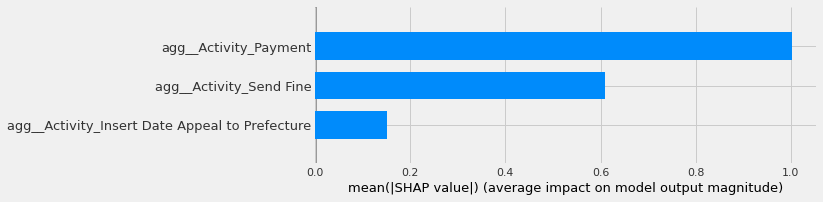

In [266]:
shap_values = shap.TreeExplainer(cls_xgb).shap_values(dt_train_named[columns])
shap.summary_plot(shap_values, dt_train_named, plot_type="bar", max_display=12)

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(dt_train_named.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(12)

In [ ]:
cols = list(feature_importance['col_name'][0:22])

In [ ]:
cols

In [ ]:
for i in cols:
    print(i)

In [ ]:
shap.summary_plot(shap_values, dt_train_named[columns])

In [ ]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,dt_train_named[columns]) 

### Parsimony

In [ ]:
#### LLM

In [179]:
len(dt_train_named_original[columns].columns)

3

In [180]:
p1 = (3-orig_coef_1[0].tolist().count(0))

p2 = (3-orig_coef_1[0].tolist().count(0))

In [185]:
(p1+p2)/2

2.0

In [184]:
p2

2

In [228]:
#### GLRM

for i in cls.explain()['rule']:
    print(i)

(intercept)
agg__Activity_Payment <= 0.00
agg__Activity_Send Fine  
agg__Activity_Payment <= 0.00 AND agg__Activity_Send Fine  
agg__Activity_Insert Date Appeal to Prefecture  


In [268]:
#### XGB

cls_xgb.feature_importances_

array([0.49253103, 0.3837639 , 0.12370507], dtype=float32)

In [269]:
df_shap = shap_values
df = dt_train_named[columns]

In [270]:
shap_v = pd.DataFrame(df_shap)
feature_list = df.columns
shap_v.columns = feature_list
df_v = df.copy().reset_index().drop('index',axis=1)

In [271]:
# Plot it
shap_abs = np.abs(shap_v)
k=pd.DataFrame(shap_abs.mean()).reset_index()
k.columns = ['Variable','SHAP_abs']

In [273]:
par = 0
for i in range(0,len(k)):
    if k['SHAP_abs'][i]>0:
        par = par+1

par

3

In [274]:
len(dt_train_named.columns)

3

In [188]:
### FC

#### LLM 

def functional_complexity(test_data, n_instances):

    result = test_data.copy()
    result2 = result.copy()
    list_of_sets=[]
    set_of_values = set()
    NF = 0
    #the different values of each column in a set
    #all these sets are added to the list_of_sets list
    for i in range(0,len(result2.columns)):
        set_of_values = set(result2.iloc[:,i])
        list_of_sets.append(set_of_values)
    

    for j in range(0,len(result2.columns)):
        if len(list_of_sets[j]) <2:
            continue
        else:
            for i in range(0,n_instances):
                new_set = list_of_sets[j].copy()
                new_set.remove(result2.iloc[i,j])
                new_value = random.choice(list(new_set))
                result2.iloc[i,j] = new_value
                pred1 = logreg.predict(pd.DataFrame(result.iloc[:]))
                pred2 = logreg.predict(pd.DataFrame(result2.iloc[:]))
                if pred1[i] != pred2[i]:
                    NF = NF+1       
    return NF/(n_instances)

functional_complexity(dt_test_named_original[columns], 500)

0.0

In [ ]:
#### GLRM

In [235]:
def functional_complexity(test_data, n_instances):

    result = test_data.copy()
    result2 = result.copy()
    list_of_sets=[]
    set_of_values = set()
    NF = 0
    #the different values of each column in a set
    #all these sets are added to the list_of_sets list
    for i in range(0,len(result2.columns)):
        set_of_values = set(result2.iloc[:,i])
        list_of_sets.append(set_of_values)
    

    for j in range(0,len(result2.columns)):
        if len(list_of_sets[j]) <2:
            continue
        else:
            for i in range(0,n_instances):
                new_set = list_of_sets[j].copy()
                new_set.remove(result2.iloc[i,j])
                new_value = random.choice(list(new_set))
                result2.iloc[i,j] = new_value
                x_1 = pd.DataFrame(result2.iloc[:])
               # print(x_1)
                x_1, x_1_std = fb.transform(pd.DataFrame(result.iloc[j][:]).T)
                x_2, x_2_std = fb.transform(pd.DataFrame(result.iloc[j][:]).T)
                pred1 = cls.predict(x_1)
                pred2 = cls.predict(x_2)
                if pred1 != pred2:
                    NF +=1 
    NF_total = NF/(n_instances)

    
    return NF_total


In [236]:
functional_complexity(dt_test_named_original[columns],500)

0.0

In [276]:
#### XGB

def functional_complexity(test_data, n_instances):

    result = test_data.copy()
    result2 = result.copy()
    list_of_sets=[]
    set_of_values = set()
    NF = 0
    #the different values of each column in a set
    #all these sets are added to the list_of_sets list
    for i in range(0,len(result2.columns)):
        set_of_values = set(result2.iloc[:,i])
        list_of_sets.append(set_of_values)
    

    for j in range(0,len(result2.columns)):
        if len(list_of_sets[j]) <2:
            continue
        else:
            for i in range(0,n_instances):
                new_set = list_of_sets[j].copy()
                new_set.remove(result2.iloc[i,j])
                new_value = random.choice(list(new_set))
                result2.iloc[i,j] = new_value
                pred1 = cls_xgb.predict(pd.DataFrame(result.iloc[i][:]).T)
                pred2 = cls_xgb.predict(pd.DataFrame(result2.iloc[i][:]).T)
                if pred1 != pred2:
                    NF = NF+1       
    return NF/(n_instances)

In [277]:
functional_complexity(dt_test_named, 500)

1.698

In [278]:
1.698/3

0.566

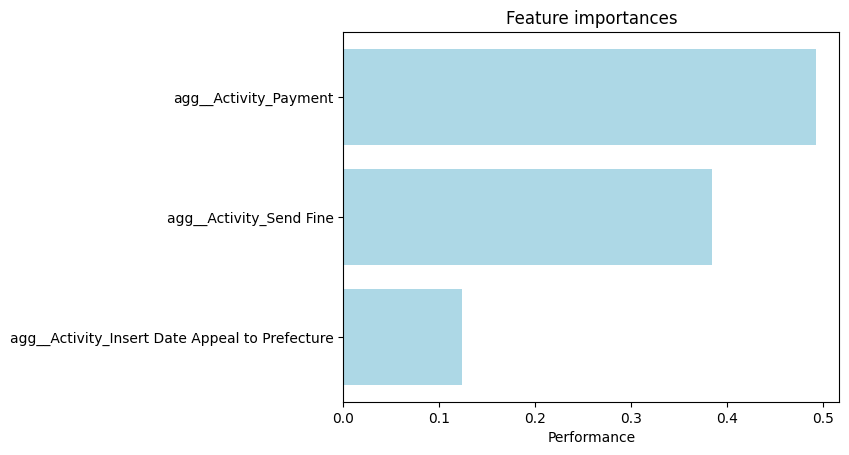

In [280]:
### Monotonicity

#XGB feature importance

feature_importance_xgb=pd.DataFrame()
feature_importance_xgb['columns']=dt_train_named_original[columns].columns
feature_importance_xgb['importances_xgb'] = cls_xgb.feature_importances_
#feature_importance_xgb.sort_values(by='importances_xgb',ascending=False,inplace=True)
#feature_importance_xgb[:10]

height = list(feature_importance_xgb['columns'][:10])
bars = list(feature_importance_xgb['importances_xgb'][:10])

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(height))
performance = bars

ax.barh(y_pos, performance, align='center',color='lightblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(height)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Feature importances')

plt.show()

In [281]:
#shap value feature importance

res = [sum(x) / len(x) for x in zip(*abs(shap_values))]

shap_importances=pd.DataFrame()
shap_importances['columns']=dt_train_named_original[columns].columns
shap_importances['importances_shap'] = res



resulting_frame = pd.concat([shap_importances, feature_importance_xgb], join='inner', axis=1)

resulting_frame.sort_values(by='importances_xgb',ascending=False,inplace=True)
resulting_frame[:10]

,columns,importances_shap,columns,importances_xgb
0,agg__Activity_Payment,1.000657,agg__Activity_Payment,0.492531
1,agg__Activity_Send Fine,0.608049,agg__Activity_Send Fine,0.383764
2,agg__Activity_Insert Date Appeal to Prefecture,0.151716,agg__Activity_Insert Date Appeal to Prefecture,0.123705


In [282]:
from scipy.stats import kendalltau

coef, p = kendalltau(resulting_frame['importances_shap'], resulting_frame['importances_xgb'])
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: 1.000
Samples are uncorrelated (fail to reject H0) p=0.333


In [283]:
from scipy.stats import spearmanr
# seed random number generator

# prepare data

coef, p = spearmanr(resulting_frame['importances_shap'], resulting_frame['importances_xgb'])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)


Spearmans correlation coefficient: 1.000
Samples are correlated (reject H0) p=0.000


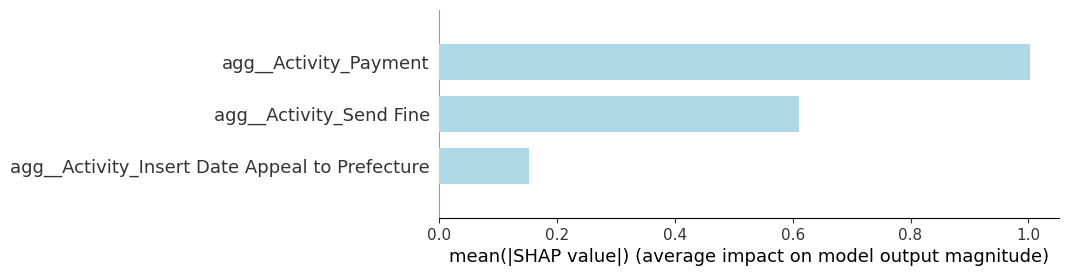

In [285]:
plt.grid(False)
#shap_values = shap.TreeExplainer(cls_xgb).shap_values(dt_train_named)
shap.summary_plot(shap_values, dt_train_named, plot_type="bar", max_display=10, color='lightblue')
ax.set(facecolor = "orange")
plt.show()